# GDP's Influence on Life Expectancy


### Pretext:
* _Life expectancy_, a figure representing the number of years, based on known statistics, to which any person of a given age may reasonably expect to live[1] 
* _Gross Domestic Product_, (GDP), the total value of goods produced and services provided in a country during one year[2]

## Hypothesis and Null Hypothesis
* This project's Hypothesis is that GDP significantly influences LEABY
* This project's Null Hypothesis is that GDP does not influence LEABY, or not to a significant extent


## Mission Statement:
In this project we will analyize the relationship between life expectancy at birth (years) (LEABY) and Gross Domestic Product (GDP) from the World Health Organization, and the World Bank of ten countries (Argentina, Chile, China, Germany, Israel, Mexico, United States of America(USA), Vietnam and Zimbabwe, between the years 2000 and 2021. I chose these countries because they should be representative of there political regions, or are known outliers, in the case of Argentina and Japan. These countries are stored in a variable, and you are able to change which countries are analyized by adding or removing them from that variable 

During this project we will plot and analyze data to try to answer the following questions:

* Does GDP have an influence on LEABY?
* How does LEABY vary by country?
* Are the small fluctiations in LEABY related between countries of similar GDP?
* How does GDP vary by country?
* Do any countries outside of our initial scope contradict our findings?

### Data Sources:
* [Life expectancy and Healthy life expectancy
Data by country - WHO](https://apps.who.int/gho/data/node.main.688)
* [World Gross Domestic Product](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)

# Global Variable
* Add or remove countries from this list, and they will be added to the analysis
* You will need to run the cells to view it
* My commentary will stay the same

In [68]:
# Storing our target countries in a variable, Add or remove a country from this list to change the charts

countries = ['Argentina',
             'Chile', 
             'China', 
             'Germany',
             'Israel',
             'Japan',
             'Mexico', 
             'United States',  
             'Zimbabwe']

# Libraries, Inspect, Tidy, Concatenate

In [129]:
# import library

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import statsmodels
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# read CSV
GDP_raw = pd.read_csv("/Users/Shared/Documents/Stats CSV/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_5358352/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_5358352.csv")

LEABY_raw = pd.read_csv("/Users/Shared/Documents/Stats CSV/WHOSIS_000001,WHOSIS_000015,WHOSIS_000002,WHOSIS_000007.csv")

# replace "United States of America" with "United States"
LEABY_raw['Country'] = LEABY_raw['Country'].replace("United States of America", "United States")

#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|# GDP TIDY |#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|

# isolate the countries from GDP_raw into a new series
mask_gdp = GDP_raw['Country_Name'].isin(countries)
GDP = GDP_raw[mask_gdp]

# drop unused GDP columns
GDP_columns_to_remove = ['Country_Code', 'Indicator_Name', 'Indicator_Code', 'Unnamed: 66','1960','1961','1962','1963','1964','1965','1966',
'1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982',
'1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2001','2002','2003',
'2004','2005','2006','2007','2008','2009','2011','2012','2013','2014','2016','2017','2018','2020','2021']
GDP = GDP.drop(columns=GDP_columns_to_remove, axis=1)

# melt GDP to match LEABY format
GDP_melt = pd.melt(GDP, id_vars=['Country_Name'], var_name='Year', value_name='Value')
GDP_melt['Country_Name'] = GDP_melt['Country_Name']
GDP = GDP_melt[['Country_Name', 'Value']].apply(lambda x: ','.join(x.astype(str)), axis=1)

# split GDP into two columns
GDP = GDP.str.split(',', expand=True)
GDP.columns = ['Country', 'GDP']

# sort value by Country, (kind = 'stable' is neccesary, or else the GDP value order will not be preserved)
GDP = GDP.sort_values(by='Country',ignore_index = True, kind = "stable")
GDP = GDP.reset_index(drop=True)

#create GDP dataframe
GDP = pd.DataFrame(GDP)
GDP.columns = ['Country','GDP']

#enhance
GDP.drop(columns=['Country'], inplace=True)

    
#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#| LEABY TIDY #|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#|#

# isolate countries from LEABY_raw in to a new series and rename columns
new_LEABY_colnames =  {
  'Life expectancy at birth (years)': 'life_ex_birth_all',
  'Life expectancy at birth (years).1': 'life_ex_birth_male',
  'Life expectancy at birth (years).2': 'life_ex_birth_female',
  'Life expectancy at age 60 (years)': 'life_ex_age_60_all',
  'Life expectancy at age 60 (years).1': 'life_ex_age_60_male',
  'Life expectancy at age 60 (years).2': 'life_ex_age_60_female',
  'Healthy life expectancy (HALE) at birth (years)': 'hale_birth_all',
  'Healthy life expectancy (HALE) at birth (years).1': 'hale_birth_male',
  'Healthy life expectancy (HALE) at birth (years).2': 'hale_birth_female',
  'Healthy life expectancy (HALE) at age 60 (years)': 'hale_age_60_all',
  'Healthy life expectancy (HALE) at age 60 (years).1': 'hale_age_60_male',
  'Healthy life expectancy (HALE) at age 60 (years).2': 'hale_age_60_female'
}

# rename LEABY columns, and drop unused countries
LEABY = LEABY_raw.rename(columns = new_LEABY_colnames)
LEABY = LEABY.drop(LEABY.index[0])
mask_LEABY = LEABY['Country'].isin(countries)
LEABY = LEABY[mask_LEABY]

# make a dataframe
LEABY = pd.DataFrame(LEABY)

# list LEABY countries from low to high (they are in groups of 4 rows that are high to low)
for i in range(0, len(LEABY), 4):
    LEABY.iloc[i:i+4] = LEABY.iloc[i:i+4].values[::-1]
    
# integrate GDP in to LEABY
LEABY = LEABY.reset_index()
LEABY['GDP'] = GDP

# replace "United States of America" with "United States"
LEABY['Country'] = LEABY['Country'].replace("United States of America", "United States")

# pandas thinks numbers aren't numeric, boy was it wrong.
cols_to_convert = LEABY.select_dtypes(include='object').columns.drop(['Country','Year'])
LEABY[cols_to_convert] = LEABY[cols_to_convert].astype(float)

# variables
year = LEABY["Year"]
#ax = plt.subplot()

# inspect
#print(LEABY.columns)

#print(GDP_raw.columns)


Any feedback on the previous section is appriciated

# Changes of LEABYxGDP Over Time

* As you can see, there is a general increase in LEABY over our sample window. 
* There is also a general increase in GDP in our sample window
* Other than a general increase across the board, GDP value gains are not visibly correlated with LEABY gains
* A good example of this is the United States have a near doubling of GDP in our sample window, with ~2% increase in LEABY

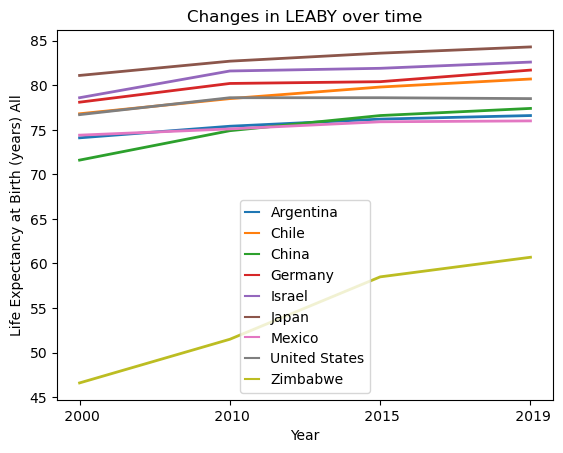

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:

# LEABY plot
sns.lineplot(x = year, y = LEABY["life_ex_birth_all"], hue= LEABY['Country'], linewidth = 2)
plt.legend(loc = "best", handlelength=1)
plt.title("Changes in LEABY over time")
plt.ylabel('Life Expectancy at Birth (years) All')
# show LEABY
plt.show()
plt.clf()

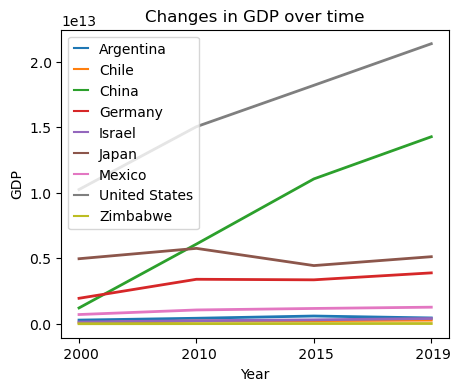

<Figure size 640x480 with 0 Axes>

In [15]:
# GDP plot
plt.figure(figsize=(5,4)) 
sns.lineplot(x = year, y = LEABY["GDP"], hue= LEABY['Country'], linewidth = 2)
plt.legend(loc = "best", handlelength=1)
plt.title("Changes in GDP over time")
plt.ylabel('GDP')
# show GDP
plt.show()
plt.clf()

# Limits on LEABY
* The below chart is a distribution of above and below average LEABY
* We can see that once a certain LEABY is reached, there is not much growth after that
* If GDP and LEABY were directly correlated, citizens of wealthy countries would live to be over 100 years old and this plot would have a normal distribution.

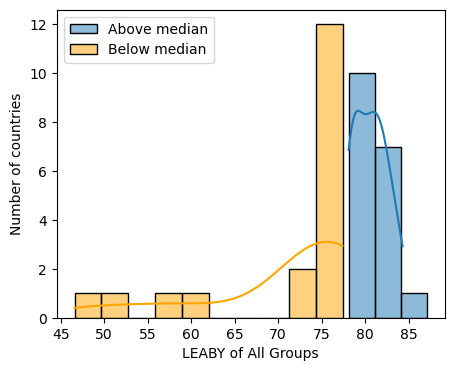

In [11]:
med_LEABYa = LEABY.life_ex_birth_all.median()

high_LEABYa = LEABY[LEABY['life_ex_birth_all'] >= med_LEABYa]
low_LEABYa = LEABY[LEABY['life_ex_birth_all'] <= med_LEABYa]

plt.figure(figsize=(5,4))
sns.histplot(high_LEABYa, x='life_ex_birth_all', label='Above Average', kde=True,binwidth = 3)
sns.histplot(low_LEABYa, x='life_ex_birth_all', label='Below Average', kde=True, color='orange', alpha=0.5)
plt.xlabel("LEABY of All Groups")
plt.ylabel("Number of countries")
plt.legend()
plt.show()


# LEABY vs GDP


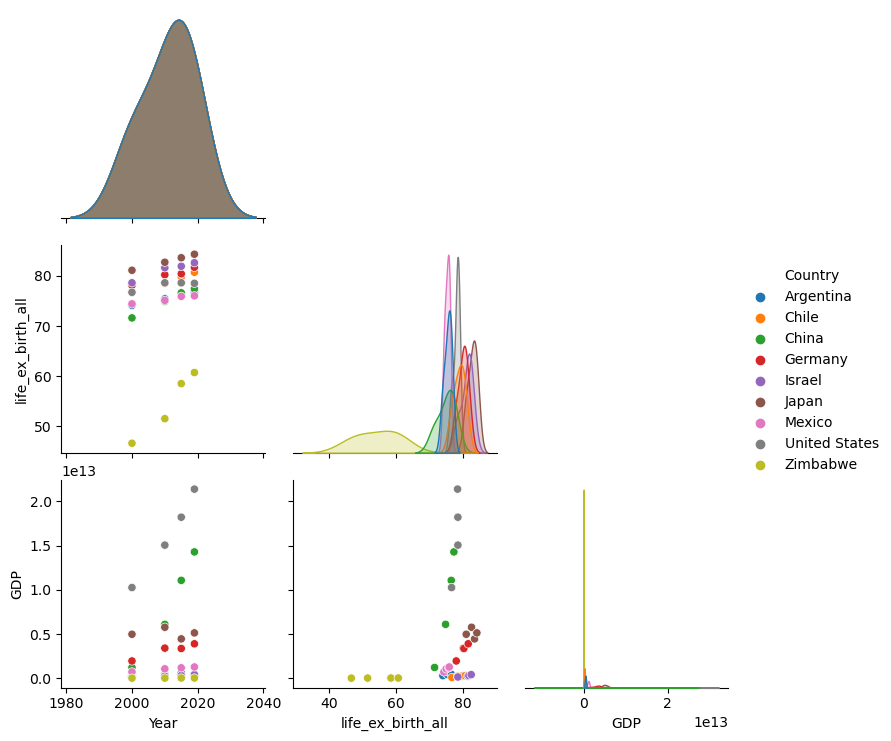

Index(['Country', 'Year', 'life_ex_birth_all', 'GDP'], dtype='object')


<Figure size 640x480 with 0 Axes>

In [131]:
LEABY_drop_pairplot = ['index','life_ex_birth_male',
       'life_ex_birth_female', 'life_ex_age_60_all', 'life_ex_age_60_male',
       'life_ex_age_60_female', 'hale_birth_all', 'hale_birth_male',
       'hale_birth_female', 'hale_age_60_all', 'hale_age_60_male',
       'hale_age_60_female']
LEABY_pairplot = LEABY.drop(columns=LEABY_drop_pairplot, axis=1)

LEABY_pairplot['Year'] = LEABY['Year'].astype(float)


['index', 'Country', 'Year', 'life_ex_birth_all', 'GDP']



sns.pairplot(LEABY_pairplot, hue = "Country",corner = True)
plt.show()
plt.clf()


#g = sns.pairplot(LEABY, vars=['index', 'Country', 'Year', 'life_ex_birth_all', 'GDP'], plot_kws={"yscale": "log"})

# Show the plot
#sns.plt.show()


#print(LEABY_pairplot.columns)


## Spearman R Correlation Coefficient
* The Spearman r correlation coeficient gives a number value between -1 and 1 to describe how closesly the relationship between two variables aligns with a curve.
* This is used to calculate how much effect one variable has on another
* In the barchart below, I have plotted the Sperman r correlation for GDP and the various LEABY values
* GDP has less of a correlation with healthy (HALE) LEABY

Spearman's rank correlation coefficient between GDP and All LEABY: 0.348
P-value: 0.038


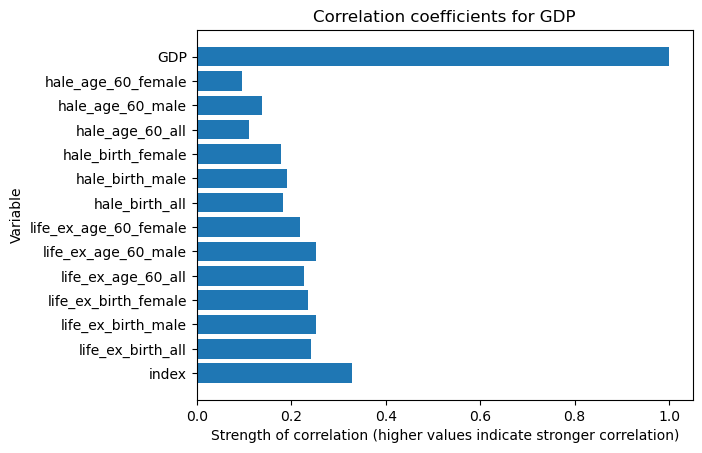

<Figure size 640x480 with 0 Axes>

In [135]:
#spearman r correlation coefficient
corr, p_value = spearmanr(LEABY['GDP'], LEABY['life_ex_birth_all'])

# print the result
print(f"Spearman's rank correlation coefficient between GDP and All LEABY: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

# Compute the correlation matrix
LEABY_corr = LEABY.corr()

# Select GDP to plot against
row_name = "GDP"
corr_row = LEABY_corr[row_name]

#plot
plt.barh(corr_row.index, corr_row)
plt.title(f"Correlation coefficients for {row_name}")
plt.xlabel("Strength of correlation (higher values indicate stronger correlation)")
plt.ylabel("Variable")
plt.show()
plt.clf()

# Conclusion

Through this analysis we can see that GDP and LEABY have a weak positive correlation, specifically with unhealthy individuals. We can also see an upper limit of human lifespan that is not affected by GDP, with minor differences between high GDP countries likely caused by culture and diet.